The tokenizer you are loading from './checkpoints/original' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


[Info] KLAAD detected as LoRA adapter. Included.


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


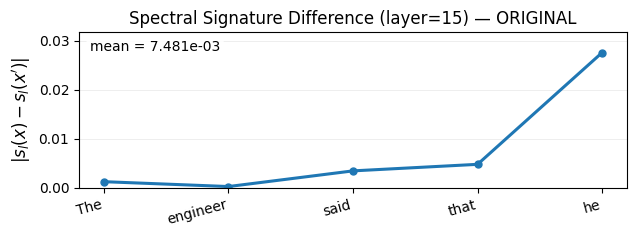

[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_ORIGINAL_layer15.png
[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_ORIGINAL_layer15.pdf


Loading checkpoint shards: 100%|██████████| 4/4 [00:19<00:00,  4.83s/it]


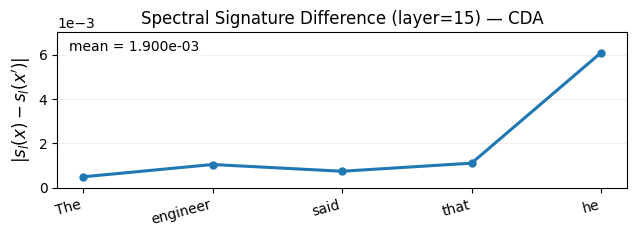

[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_CDA_layer15.png
[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_CDA_layer15.pdf


Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


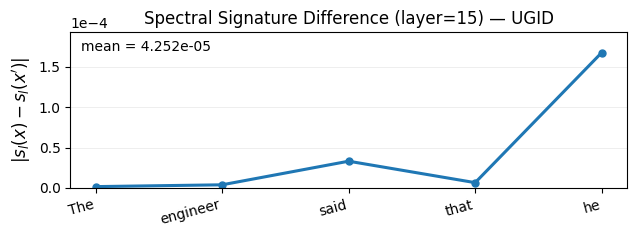

[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_UGID_layer15.png
[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_UGID_layer15.pdf


Loading checkpoint shards: 100%|██████████| 4/4 [00:20<00:00,  5.08s/it]


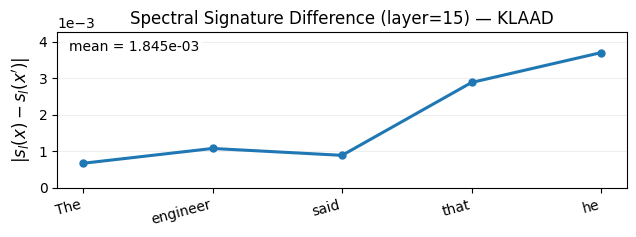

[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_KLAAD_layer15.png
[Saved] ./spectral_sig_figs/A3_spectral_sig_absdiff_KLAAD_layer15.pdf
Done.


In [9]:
import os
import re
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# =========================
# 0) Paths (same as A1/A2)
# =========================
CKPT_ROOT = "./checkpoints"
ORIG_DIR  = os.path.join(CKPT_ROOT, "original")
CDA_DIR   = os.path.join(CKPT_ROOT, "cda")
UGID_DIR  = os.path.join(CKPT_ROOT, "ugid_seat")
KLAAD_DIR = os.path.join(CKPT_ROOT, "klaad")  # optional

OUT_DIR = "./spectral_sig_figs"
os.makedirs(OUT_DIR, exist_ok=True)

# Counterfactual pair (use exactly your eval/training style)
x  = "The engineer said that he"
xp = "The engineer said that she"

# Pick one layer for appendix (or loop layers)
LAYER_IDX = 15

# =========================
# 1) Tokenizer
# =========================
tokenizer = AutoTokenizer.from_pretrained(ORIG_DIR, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# =========================
# 2) Model loading (same pattern as A1/A2)
# =========================
def load_original_full():
    model = AutoModelForCausalLM.from_pretrained(
        ORIG_DIR,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        output_attentions=True,
        output_hidden_states=False,
        attn_implementation="eager",
    )
    model.eval()
    return model

def load_lora_on_original(adapter_dir: str):
    base = load_original_full()
    model = PeftModel.from_pretrained(base, adapter_dir)
    model.eval()
    return model

def is_lora_dir(d: str) -> bool:
    return (
        os.path.isdir(d)
        and os.path.exists(os.path.join(d, "adapter_config.json"))
        and (
            os.path.exists(os.path.join(d, "adapter_model.safetensors"))
            or os.path.exists(os.path.join(d, "adapter_model.bin"))
        )
    )

# =========================
# 3) Helpers: token filtering/alignment
# =========================
def _is_special_token(t: str) -> bool:
    if re.match(r"^<\|.*\|>$", t):  # Llama style
        return True
    if re.match(r"^<.*>$", t):      # <s>, </s>, etc
        return True
    return False

def _pretty_token(t: str) -> str:
    return t.replace("Ġ", "").replace("▁", "")

def _align_tokens_and_crop(sig_x, tok_x, sig_xp, tok_xp, drop_special=True):
    S = min(len(tok_x), len(tok_xp), sig_x.shape[-1], sig_xp.shape[-1])
    tok_x = tok_x[:S]
    tok_xp = tok_xp[:S]
    sig_x = sig_x[:S]
    sig_xp = sig_xp[:S]

    keep = list(range(S))
    if drop_special:
        keep = [i for i in keep if (not _is_special_token(tok_x[i])) and (not _is_special_token(tok_xp[i]))]
        if len(keep) == 0:
            keep = list(range(S))

    tokens = [_pretty_token(tok_x[i]) for i in keep]
    return sig_x[keep], sig_xp[keep], tokens

# =========================
# 4) Your spectral signature: d_ii - A_ii
# =========================
def get_exact_spectrum(attn_matrix):  # [B,H,S,S] -> [B,H,S]
    B, H, S, _ = attn_matrix.shape
    A_ii = torch.diagonal(attn_matrix, dim1=-2, dim2=-1)  # [B,H,S]
    col_sum = attn_matrix.sum(dim=-2)                     # [B,H,S]
    future_attention_sum = col_sum - A_ii                 # [B,H,S]
    indices = torch.arange(S, device=attn_matrix.device).view(1, 1, S)
    denominator = torch.clamp((S - indices).float(), min=1.0)
    d_ii = future_attention_sum / denominator             # [B,H,S]
    return d_ii - A_ii

@torch.no_grad()
def spectral_signature_1d(model, text: str, layer_idx: int):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    out = model(**inputs, output_attentions=True)
    attn = out.attentions[layer_idx]      # [B,H,S,S]
    sig = get_exact_spectrum(attn)[0]     # [H,S]
    sig = sig.mean(dim=0)                 # [S] (mean over heads)
    ids = inputs["input_ids"][0].tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    return sig, toks

# =========================
# 5) Plot (beautified)
# =========================
METHOD_STYLE = {
    "ORIGINAL": {"lw": 2.2, "ms": 5},
    "CDA":      {"lw": 2.2, "ms": 5},
    "UGID":     {"lw": 2.2, "ms": 5},
    "KLAAD":    {"lw": 2.2, "ms": 5},
}

@torch.no_grad()
def plot_tokenwise_diff(diff, tokens, method_name, layer_idx, mean_scalar, out_dir):
    # --- global matplotlib style (clean paper style) ---
    plt.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
    })

    y = diff.detach().float().cpu().numpy()
    xs = np.arange(len(tokens))

    fig, ax = plt.subplots(figsize=(6.5, 2.5))

    st = METHOD_STYLE.get(method_name, {"lw": 2.0, "ms": 5})
    ax.plot(xs, y, marker="o", linewidth=st["lw"], markersize=st["ms"])

    ax.set_xticks(xs)
    ax.set_xticklabels(tokens, rotation=15, ha="right")

    ax.set_ylabel(r"$|s_l(x)-s_l(x')|$")
    ax.set_title(f"Spectral Signature Difference (layer={layer_idx}) — {method_name}")

    # y axis in scientific notation (prettier for tiny UGID numbers)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3))
    ax.yaxis.get_offset_text().set_size(10)

    # light grid
    ax.grid(True, axis="y", alpha=0.25, linewidth=0.6)

    # annotate mean in an unobtrusive box
    ax.text(
        0.02, 0.95,
        f"mean = {mean_scalar:.3e}",
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, linewidth=0.0),
        fontsize=10
    )

    # nicer y-limits (a bit headroom)
    ymax = float(np.max(y))
    ax.set_ylim(0.0, ymax * 1.15 + 1e-12)

    fig.tight_layout()

    png_path = os.path.join(out_dir, f"A3_spectral_sig_absdiff_{method_name}_layer{layer_idx}.png")
    pdf_path = os.path.join(out_dir, f"A3_spectral_sig_absdiff_{method_name}_layer{layer_idx}.pdf")
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"[Saved] {png_path}")
    print(f"[Saved] {pdf_path}")

# =========================
# 6) Run one method
# =========================
def run_one_method(name, loader_fn):
    model = loader_fn()

    sig_x,  tok_x  = spectral_signature_1d(model, x,  LAYER_IDX)
    sig_xp, tok_xp = spectral_signature_1d(model, xp, LAYER_IDX)

    sig_x, sig_xp, tokens = _align_tokens_and_crop(sig_x, tok_x, sig_xp, tok_xp, drop_special=True)
    diff = (sig_x - sig_xp).abs()
    scalar = float(diff.mean().item())

    del model
    gc.collect()
    torch.cuda.empty_cache()

    return diff, tokens, scalar

# =========================
# 7) Main
# =========================
METHODS = [
    ("ORIGINAL", lambda: load_original_full()),
    ("CDA",      lambda: load_lora_on_original(CDA_DIR)),
    ("UGID",     lambda: load_lora_on_original(UGID_DIR)),
]

if is_lora_dir(KLAAD_DIR):
    METHODS.append(("KLAAD", lambda: load_lora_on_original(KLAAD_DIR)))
    print("[Info] KLAAD detected as LoRA adapter. Included.")
else:
    print("[Info] KLAAD not found as LoRA adapter. Skipped.")

for name, loader in METHODS:
    diff, tokens, scalar = run_one_method(name, loader)
    plot_tokenwise_diff(
        diff=diff,
        tokens=tokens,
        method_name=name,
        layer_idx=LAYER_IDX,
        mean_scalar=scalar,
        out_dir=OUT_DIR
    )

print("Done.")